<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
# imports

import pmdarima as pm
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import log
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [2]:
# bringing in our 4 dataframes
public_data = pd.read_csv(
    "COVID-19_Aggregate_Cases_Current_Weekly_County_Health.csv")
google_data_2020 = pd.read_csv(
    "2020_sub_region_1_daily_2020_US_Pennsylvania_daily_symptoms_dataset.csv",  dtype=str)
google_data_2021 = pd.read_csv(
    "2021_sub_region_1_daily_2021_US_Pennsylvania_daily_symptoms_dataset(1).csv", dtype=str)
google_data_2022 = pd.read_csv(
    "2022_sub_region_1_daily_2022_US_Pennsylvania_daily_symptoms_dataset(1).csv", dtype=str)

In [3]:
# consolidating our google data into one dataframe
google_dataframes = [google_data_2020, google_data_2021, google_data_2022]
google_data = pd.concat(google_dataframes)
google_data.head()

,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,place_id,date,symptom:Abdominal obesity,symptom:Abdominal pain,...,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US,United States,Pennsylvania,US-PA,NaN,NaN,ChIJieUyHiaALYgRPbQiUEchRsI,2020-01-01,2.37,4.85,...,1.22,0.24,0.34,3.29,0.38,2.49,0.35,0.16,0.47,0.38
1,US,United States,Pennsylvania,US-PA,NaN,NaN,ChIJieUyHiaALYgRPbQiUEchRsI,2020-01-02,2.28,4.74,...,1.34,0.24,0.4,3.39,0.38,2.4,0.4,0.16,0.53,0.45
2,US,United States,Pennsylvania,US-PA,NaN,NaN,ChIJieUyHiaALYgRPbQiUEchRsI,2020-01-03,2.04,4.62,...,1.23,0.23,0.38,3.17,0.34,2.19,0.38,0.16,0.51,0.41
3,US,United States,Pennsylvania,US-PA,NaN,NaN,ChIJieUyHiaALYgRPbQiUEchRsI,2020-01-04,2.25,4.83,...,1.22,0.26,0.4,3.15,0.32,2.46,0.39,0.17,0.54,0.35
4,US,United States,Pennsylvania,US-PA,NaN,NaN,ChIJieUyHiaALYgRPbQiUEchRsI,2020-01-05,2.5,4.7,...,1.19,0.25,0.37,3.38,0.34,2.5,0.38,0.16,0.53,0.36


In [4]:
google_philly = google_data[google_data.sub_region_2 == 'Philadelphia County']
google_philly.head()

,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,place_id,date,symptom:Abdominal obesity,symptom:Abdominal pain,...,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
17934,US,United States,Pennsylvania,US-PA,Philadelphia County,42101,ChIJ60u11Ni3xokRhBCHQtzJmsM,2020-01-01,2.35,4.46,...,1.09,0.2,0.31,2.95,0.32,2.55,0.31,0.19,0.37,0.25
17935,US,United States,Pennsylvania,US-PA,Philadelphia County,42101,ChIJ60u11Ni3xokRhBCHQtzJmsM,2020-01-02,2.37,4.17,...,1.14,0.19,0.37,3.01,0.27,2.63,0.34,0.14,0.5,0.34
17936,US,United States,Pennsylvania,US-PA,Philadelphia County,42101,ChIJ60u11Ni3xokRhBCHQtzJmsM,2020-01-03,2.13,4.18,...,1.08,0.17,0.32,2.95,0.29,2.46,0.3,0.18,0.51,0.3
17937,US,United States,Pennsylvania,US-PA,Philadelphia County,42101,ChIJ60u11Ni3xokRhBCHQtzJmsM,2020-01-04,2.37,4.5,...,1.1,0.18,0.37,3.26,0.28,2.78,0.42,0.24,0.48,0.27
17938,US,United States,Pennsylvania,US-PA,Philadelphia County,42101,ChIJ60u11Ni3xokRhBCHQtzJmsM,2020-01-05,2.36,4.12,...,1.12,0.21,0.28,3.21,0.25,2.82,0.35,0.2,0.49,0.24


In [5]:
# removing extraneous columns from our `google_data`
google_philly.drop(columns=["sub_region_2", "sub_region_2_code","country_region_code", "country_region", "sub_region_1",
                          "sub_region_1_code", "place_id"], inplace=True)

google_philly.head()

/var/folders/nz/h8wmnpz55qb3srn4_mj451lc0000gn/T/ipykernel_29478/101459141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_philly.drop(columns=["sub_region_2", "sub_region_2_code","country_region_code", "country_region", "sub_region_1",


,date,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,...,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
17934,2020-01-01,2.35,4.46,7.76,0.19,0.62,0.09,NaN,5.11,NaN,...,1.09,0.2,0.31,2.95,0.32,2.55,0.31,0.19,0.37,0.25
17935,2020-01-02,2.37,4.17,8.13,0.24,0.66,0.05,NaN,4.35,NaN,...,1.14,0.19,0.37,3.01,0.27,2.63,0.34,0.14,0.5,0.34
17936,2020-01-03,2.13,4.18,7.57,0.24,0.78,0.07,0.06,4.01,0.09,...,1.08,0.17,0.32,2.95,0.29,2.46,0.3,0.18,0.51,0.3
17937,2020-01-04,2.37,4.5,8.85,0.16,0.69,0.09,NaN,4.38,0.09,...,1.1,0.18,0.37,3.26,0.28,2.78,0.42,0.24,0.48,0.27
17938,2020-01-05,2.36,4.12,8.58,0.07,0.62,0.07,NaN,3.82,0.08,...,1.12,0.21,0.28,3.21,0.25,2.82,0.35,0.2,0.49,0.24


In [6]:
# make the date our index, then sort by the date index
google_philly['date'] = pd.to_datetime(google_philly['date'])
google_philly.set_index('date', inplace=True)
google_philly= google_philly.sort_index()

/var/folders/nz/h8wmnpz55qb3srn4_mj451lc0000gn/T/ipykernel_29478/2561510202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  google_philly['date'] = pd.to_datetime(google_philly['date'])


In [7]:
google_philly.head()

,symptom:Abdominal obesity,symptom:Abdominal pain,symptom:Acne,symptom:Actinic keratosis,symptom:Acute bronchitis,symptom:Adrenal crisis,symptom:Ageusia,symptom:Alcoholism,symptom:Allergic conjunctivitis,symptom:Allergy,...,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2.35,4.46,7.76,0.19,0.62,0.09,NaN,5.11,NaN,7.7,...,1.09,0.2,0.31,2.95,0.32,2.55,0.31,0.19,0.37,0.25
2020-01-02,2.37,4.17,8.13,0.24,0.66,0.05,NaN,4.35,NaN,9.17,...,1.14,0.19,0.37,3.01,0.27,2.63,0.34,0.14,0.5,0.34
2020-01-03,2.13,4.18,7.57,0.24,0.78,0.07,0.06,4.01,0.09,8.72,...,1.08,0.17,0.32,2.95,0.29,2.46,0.3,0.18,0.51,0.3
2020-01-04,2.37,4.5,8.85,0.16,0.69,0.09,NaN,4.38,0.09,8.07,...,1.1,0.18,0.37,3.26,0.28,2.78,0.42,0.24,0.48,0.27
2020-01-05,2.36,4.12,8.58,0.07,0.62,0.07,NaN,3.82,0.08,8.24,...,1.12,0.21,0.28,3.21,0.25,2.82,0.35,0.2,0.49,0.24


In [8]:
google_philly = google_philly.astype('float')

In [9]:
# https://stackoverflow.com/questions/52044348/check-for-any-missing-dates-in-the-index
# checks for any missing dates!
pd.date_range(start='2020-01-01',
              end='2022-11-13').difference(google_philly.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [10]:
# check for missing values in `google_philly`
google_philly.isnull().sum().sum()

3176

In [11]:
google_philly.fillna(0, inplace=True)

In [12]:
google_philly.isnull().sum().sum()

0

In [13]:
# code from https://stackoverflow.com/questions/55679401/remove-prefix-or-suffix-substring-from-column-headers-in-pandas
google_philly.columns = google_philly.columns.map(lambda x: x.removeprefix('symptom:')) 

In [14]:
google_philly.tail()

,Abdominal obesity,Abdominal pain,Acne,Actinic keratosis,Acute bronchitis,Adrenal crisis,Ageusia,Alcoholism,Allergic conjunctivitis,Allergy,...,Wart,Water retention,Weakness,Weight gain,Wheeze,Xeroderma,Xerostomia,Yawn,hyperhidrosis,pancreatitis
date,,,,,,,,,,,,,,,,,,,,,
2022-11-09,1.34,3.44,6.12,0.29,0.62,0.07,0.09,2.89,0.08,9.44,...,1.05,0.22,0.36,2.62,0.38,2.12,0.34,0.19,0.45,0.31
2022-11-10,1.41,3.45,6.24,0.21,0.59,0.14,0.07,3.18,0.07,9.37,...,1.01,0.20,0.38,2.60,0.28,2.06,0.35,0.13,0.39,0.27
2022-11-11,1.33,3.56,6.30,0.24,0.47,0.10,0.10,3.46,0.04,9.07,...,0.97,0.24,0.35,2.51,0.35,2.03,0.42,0.14,0.44,0.28
2022-11-12,1.42,3.68,6.82,0.22,0.45,0.10,0.06,3.54,0.07,9.30,...,1.02,0.21,0.32,2.63,0.25,2.25,0.35,0.14,0.47,0.26
2022-11-13,1.51,3.81,6.93,0.22,0.48,0.07,0.06,3.45,0.07,8.20,...,0.96,0.24,0.32,2.48,0.29,2.45,0.39,0.14,0.45,0.26


In [15]:
symptoms = pd.DataFrame()
symptoms['symptoms']= google_philly.columns.values
symptoms.to_csv("symptoms.csv")

In [16]:
google_philly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048 entries, 2020-01-01 to 2022-11-13
Columns: 422 entries, Abdominal obesity to pancreatitis
dtypes: float64(422)
memory usage: 3.4 MB


In [17]:
# start processing the public_data
public_data['Date'] = pd.to_datetime(public_data['Date'])
public_data.set_index('Date', inplace=True)
public_data = public_data.sort_index()

In [18]:
public_data

,Jurisdiction,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Georeferenced Lat & Long
Date,,,,,,,,,,,,
2020-03-01,Lancaster,0,NaN,0,545724,0.0,NaN,0.0,42071,-76.251388,40.045908,POINT (-76.25138768 40.04590796)
2020-03-01,Blair,0,NaN,0,121829,0.0,NaN,0.0,42013,-78.349077,40.485550,POINT (-78.34907687 40.48555024)
2020-03-01,Susquehanna,0,NaN,0,40328,0.0,NaN,0.0,42115,-75.802503,41.820569,POINT (-75.80250303 41.8205686)
2020-03-01,Berks,0,NaN,0,421164,0.0,NaN,0.0,42011,-75.930773,40.419396,POINT (-75.93077327 40.41939635)
2020-03-01,Clinton,0,NaN,0,38632,0.0,NaN,0.0,42035,-77.642838,41.232863,POINT (-77.6428376 41.23286274)
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-14,Dauphin,15,16.6,72765,278299,5.4,6.0,26146.3,42043,-76.779606,40.419746,POINT (-76.77960568 40.41974636)
2023-03-14,Crawford,14,12.3,25018,84629,16.5,14.5,29562.0,42039,-80.113211,41.685469,POINT (-80.11321083 41.68546907)
2023-03-14,Venango,4,4.4,13866,50668,7.9,8.7,27366.4,42121,-79.762866,41.403413,POINT (-79.76286561 41.40341259)


In [19]:
public_philly = public_data[public_data.Jurisdiction == 'Philadelphia']
# making it so the dates will match when we join the two dataframes
public_philly = public_philly.loc[: "2022-11-16"]
public_philly

,Jurisdiction,New Cases,7-day Average New Cases,Cumulative cases,Population (2019),New Case Rate,7-Day Average New Case Rate,Cumulative Case Rate,County FIPS Code,Longitude,Latitude,Georeferenced Lat & Long
Date,,,,,,,,,,,,
2020-03-01,Philadelphia,0,NaN,0,1584064,0.0,NaN,0.0,42101,-75.140236,40.004444,POINT (-75.140236 40.00444354)
2020-03-02,Philadelphia,0,NaN,0,1584064,0.0,NaN,0.0,42101,-75.140236,40.004444,POINT (-75.140236 40.00444354)
2020-03-03,Philadelphia,0,NaN,0,1584064,0.0,NaN,0.0,42101,-75.140236,40.004444,POINT (-75.140236 40.00444354)
2020-03-04,Philadelphia,0,NaN,0,1584064,0.0,NaN,0.0,42101,-75.140236,40.004444,POINT (-75.140236 40.00444354)
2020-03-05,Philadelphia,0,NaN,0,1584064,0.0,NaN,0.0,42101,-75.140236,40.004444,POINT (-75.140236 40.00444354)
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-12,Philadelphia,116,159.0,372093,1584064,7.3,10.0,23489.8,42101,-75.140236,40.004444,POINT (-75.140236 40.00444354)
2022-11-13,Philadelphia,78,157.1,372171,1584064,4.9,9.9,23494.7,42101,-75.140236,40.004444,POINT (-75.140236 40.00444354)
2022-11-14,Philadelphia,165,158.1,372336,1584064,10.4,10.0,23505.1,42101,-75.140236,40.004444,POINT (-75.140236 40.00444354)


In [20]:
google_philly = google_philly.loc["2020-03-01" : "2022-11-16"]


In [21]:
# list curated based on CDC's reccomendations: https://www.cdc.gov/coronavirus/2019-ncov/symptoms-testing/symptoms.html
selected_features = ["Ageusia", "Anosmia", "Chills", "Cough", "Diarrhea", "Fatigue", "Fever", "Headache", "Myalgia",
                     "Nausea", "Rhinorrhea", "Shortness of breath", "Sinusitis", "Sore throat", "Vomiting"]
selected_features

['Ageusia',
 'Anosmia',
 'Chills',
 'Cough',
 'Diarrhea',
 'Fatigue',
 'Fever',
 'Headache',
 'Myalgia',
 'Nausea',
 'Rhinorrhea',
 'Shortness of breath',
 'Sinusitis',
 'Sore throat',
 'Vomiting']

In [22]:
# join data sets and decide on target variable
philly_data = pd.concat([google_philly, public_philly['7-day Average New Cases']], axis=1)

target_cases = philly_data['7-day Average New Cases']
symptoms = philly_data[selected_features]

In [23]:
#testing our data and how if perfoms without the omicron spike - both pre and post
pre_omicron = philly_data.loc[: "2021-11-01"].dropna()
post_omicron = philly_data.loc["2022-03-01" :].dropna()

pre_target = pre_omicron['7-day Average New Cases']
post_target = post_omicron['7-day Average New Cases']

pre_symptoms = pre_omicron[selected_features]
post_symptoms = post_omicron[selected_features]

In [24]:
public_philly['7-day Average New Cases']

Date
2020-03-01      NaN
2020-03-02      NaN
2020-03-03      NaN
2020-03-04      NaN
2020-03-05      NaN
              ...  
2022-11-12    159.0
2022-11-13    157.1
2022-11-14    158.1
2022-11-15    152.7
2022-11-16    153.7
Name: 7-day Average New Cases, Length: 991, dtype: float64

In [25]:
#rolling_mean = public_philly["7-day Average New Cases"]
target = public_philly['7-day Average New Cases']

In [26]:
symptoms.dropna(inplace=True)

/var/folders/nz/h8wmnpz55qb3srn4_mj451lc0000gn/T/ipykernel_29478/2091940191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  symptoms.dropna(inplace=True)


In [27]:
target.dropna(inplace=True)

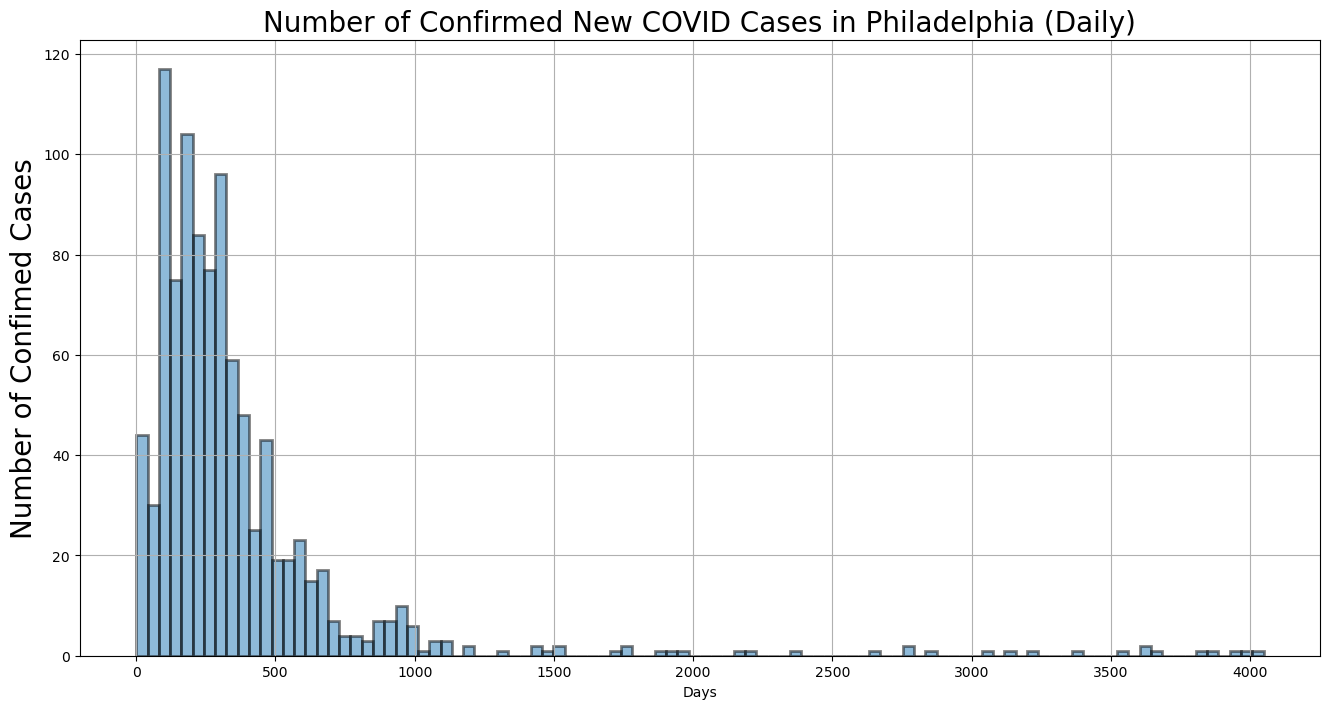

In [28]:
target.hist(bins=100, figsize=(16, 8), alpha=0.5,
            edgecolor="black", linewidth=2)
plt.title(
    'Number of Confirmed New COVID Cases in Philadelphia (Daily)', fontsize=20)
plt.xlabel('Days')
plt.ylabel('Number of Confimed Cases', fontsize=20);

In [29]:
philly_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 991 entries, 2020-03-01 to 2022-11-16
Freq: D
Columns: 423 entries, Abdominal obesity to 7-day Average New Cases
dtypes: float64(423)
memory usage: 3.2 MB


In [30]:
#this will leave us with 70% of our data in the training set, 20% in the test set, and 10% in our validation set
cutoff_test = round(len(philly_data)*.85)
cutoff_val = round(len(philly_data)*.95)

X_train = symptoms[:cutoff_test]
X_test = symptoms[cutoff_test: cutoff_val]
X_val = symptoms[cutoff_val:]

y_train = target[:cutoff_test]
y_test = target[cutoff_test: cutoff_val]
y_val = target[cutoff_val:]

In [31]:
# pre_omicron spike train test split 
cutoff_test_pre = round(len(pre_symptoms)*.85)
cutoff_val_pre = round(len(pre_symptoms)*.95)

X_train_pre = pre_symptoms[:cutoff_test_pre]
X_test_pre = pre_symptoms[cutoff_test_pre: cutoff_val_pre]
X_val_pre = pre_symptoms[cutoff_val_pre:]

y_train_pre = pre_target[:cutoff_test_pre]
y_test_pre = pre_target[cutoff_test_pre: cutoff_val_pre]
y_val_pre = pre_target[cutoff_val_pre:]

# post_omicron spike train test split 
cutoff_test_post = round(len(post_symptoms)*.85)
cutoff_val_post = round(len(post_symptoms)*.95)

X_train_post = post_symptoms[:cutoff_test_post]
X_test_post = post_symptoms[cutoff_test_post: cutoff_val_post]
X_val_post = post_symptoms[cutoff_val_post:]

y_train_post = post_target[:cutoff_test_post]
y_test_post = post_target[cutoff_test_post: cutoff_val_post]
y_val_post = post_target[cutoff_val_post:]


In [32]:
y_train_post

2022-03-01    114.0
2022-03-02    115.7
2022-03-03    130.3
2022-03-04    123.7
2022-03-05    124.4
              ...  
2022-10-01    186.7
2022-10-02    184.3
2022-10-03    185.9
2022-10-04    187.6
2022-10-05    159.1
Freq: D, Name: 7-day Average New Cases, Length: 219, dtype: float64

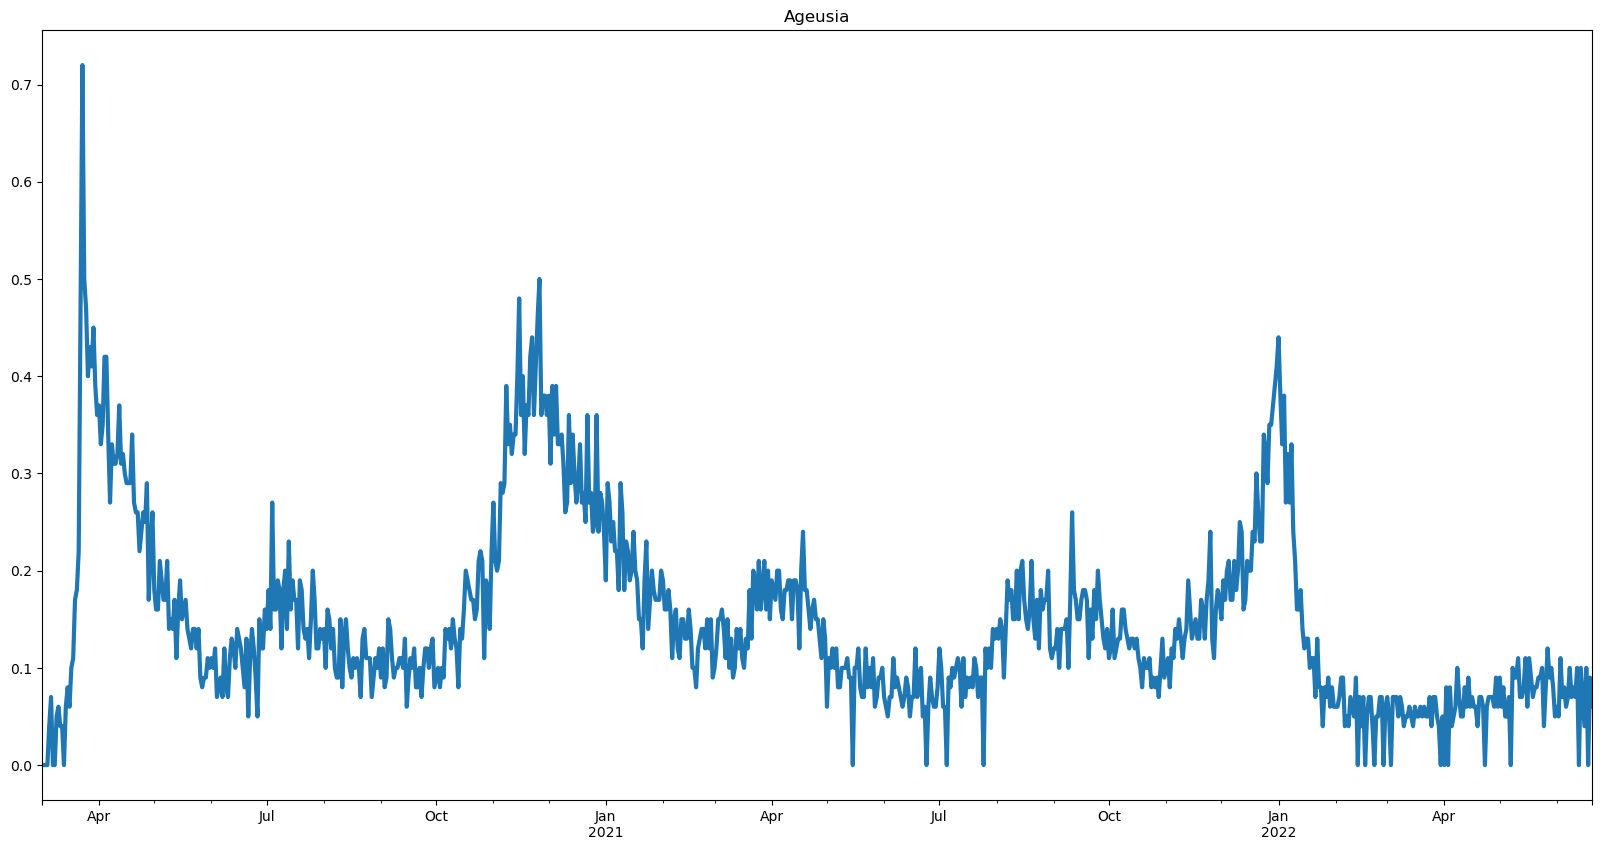

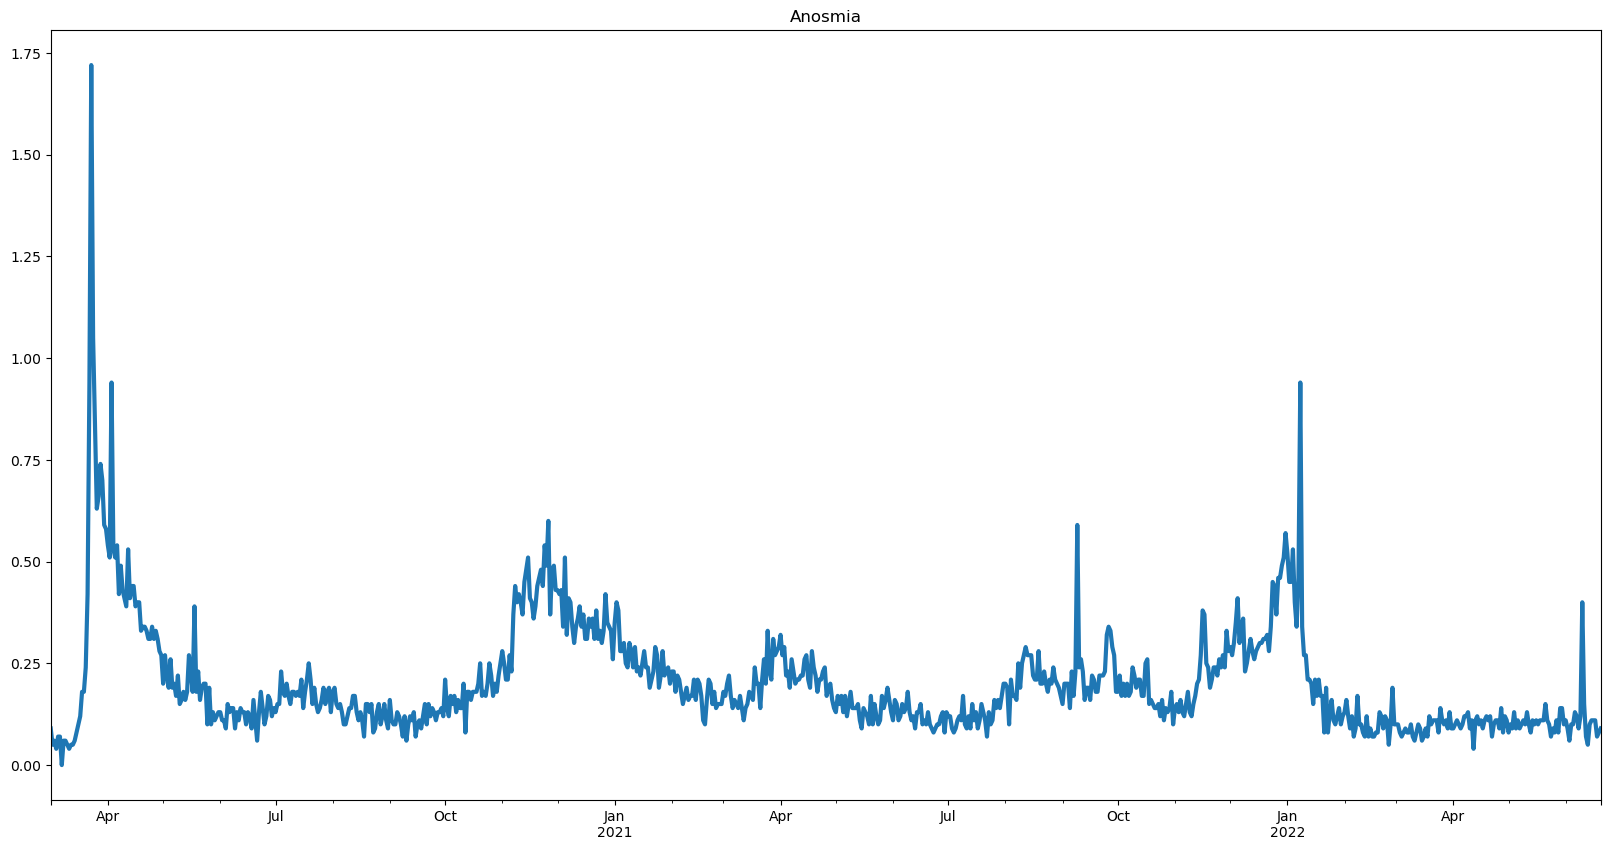

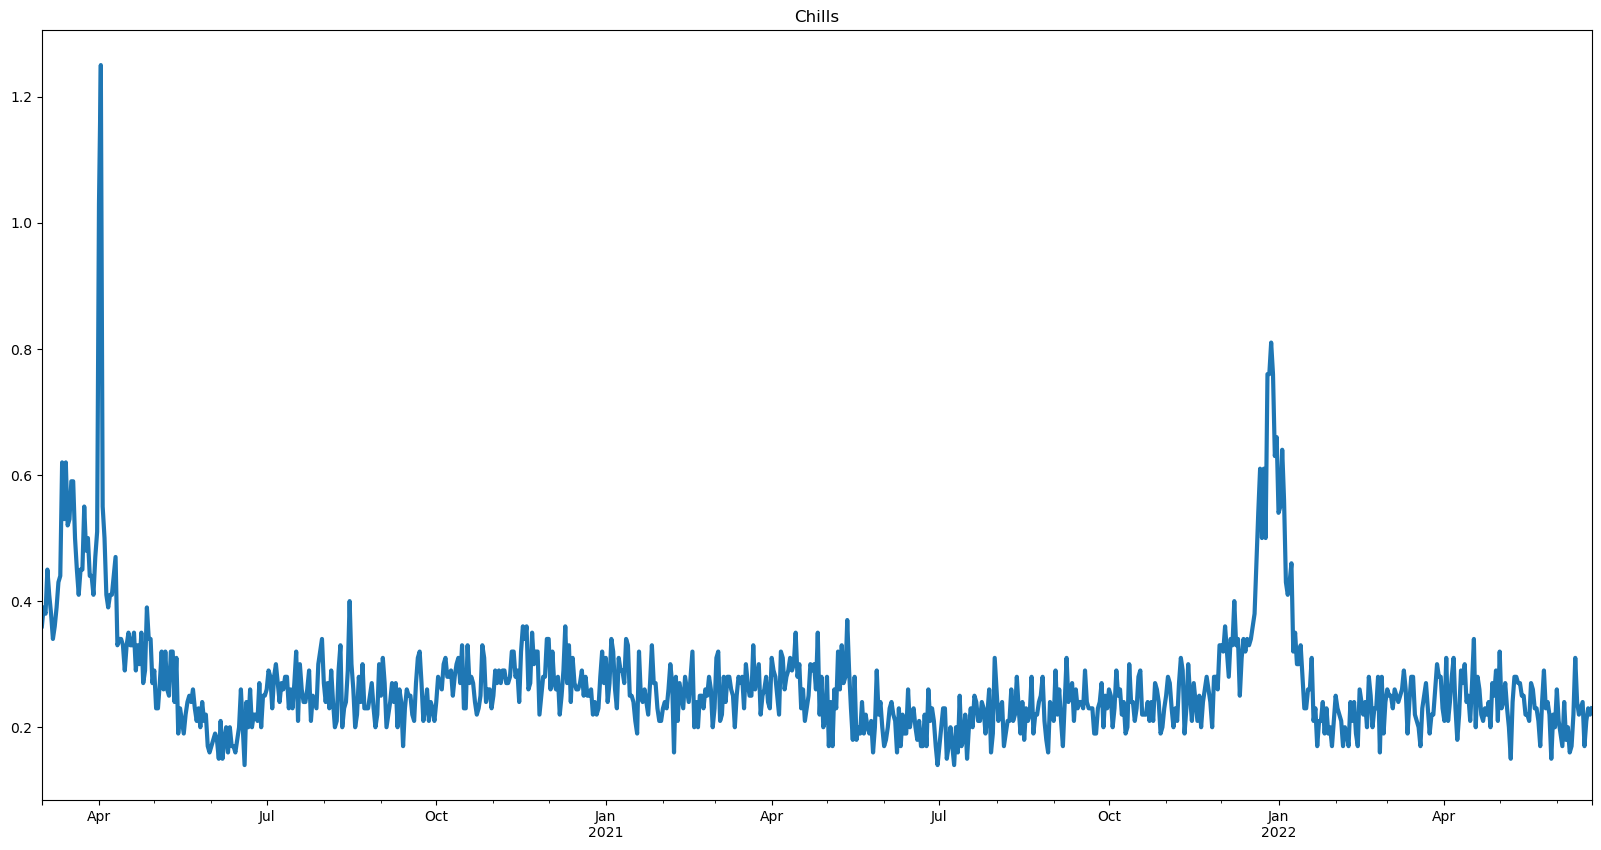

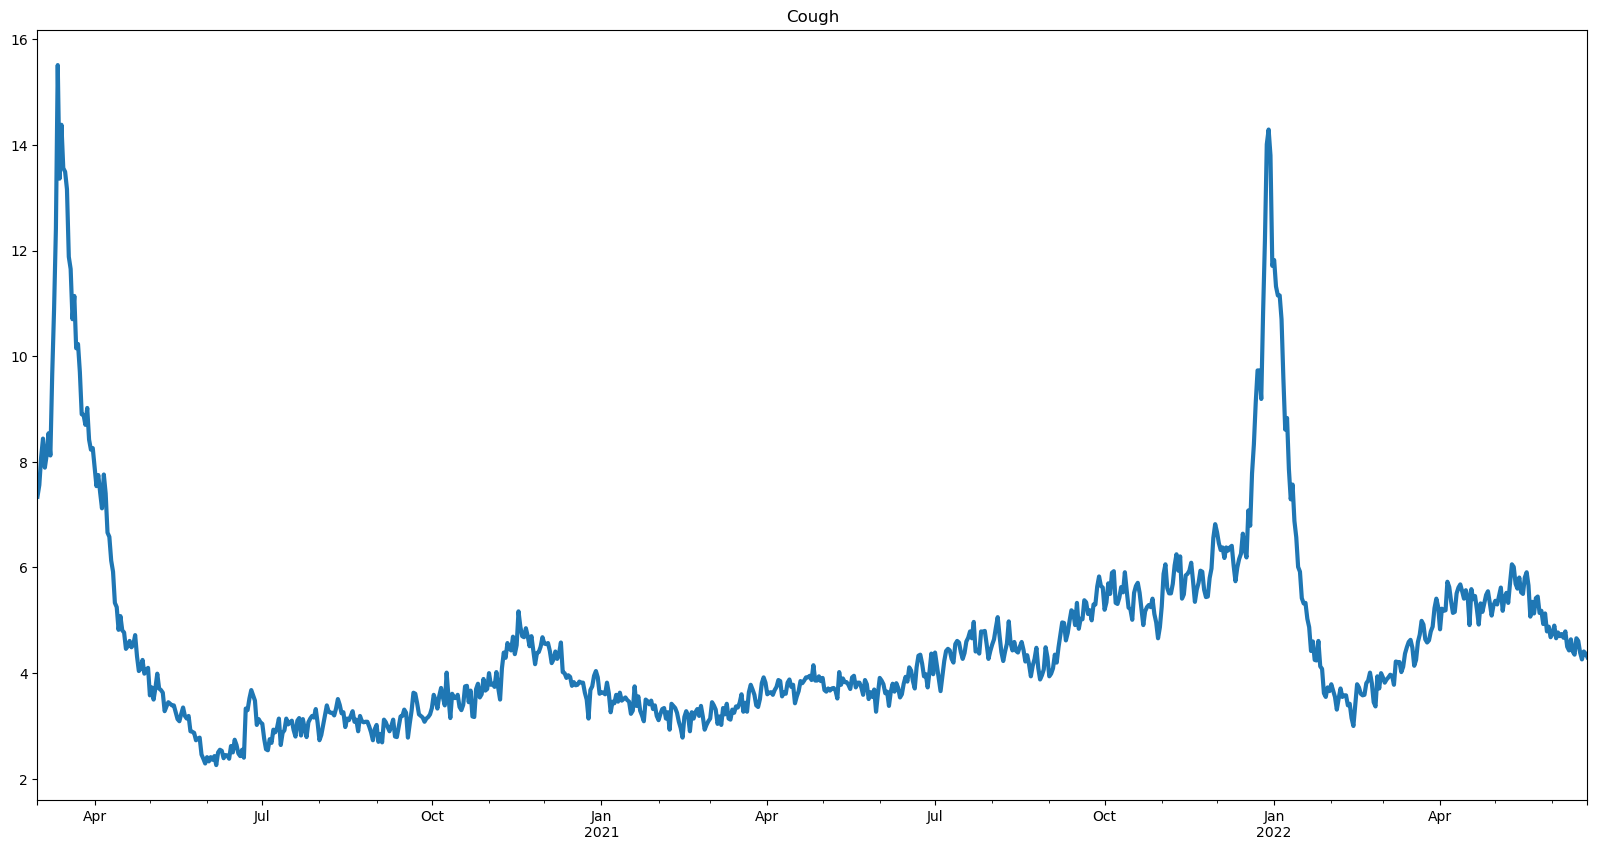

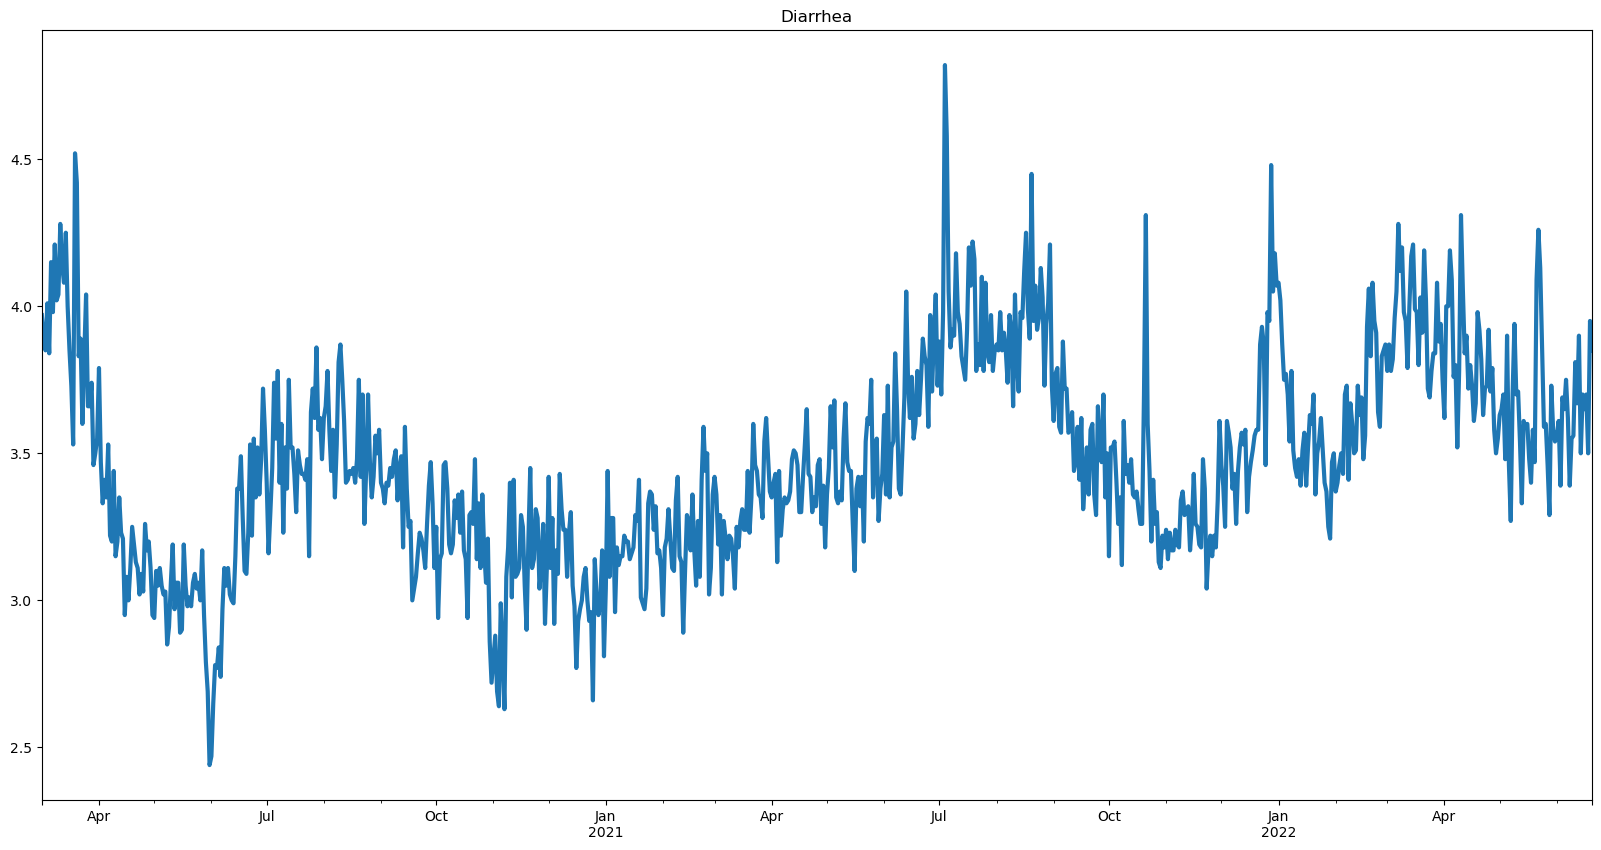

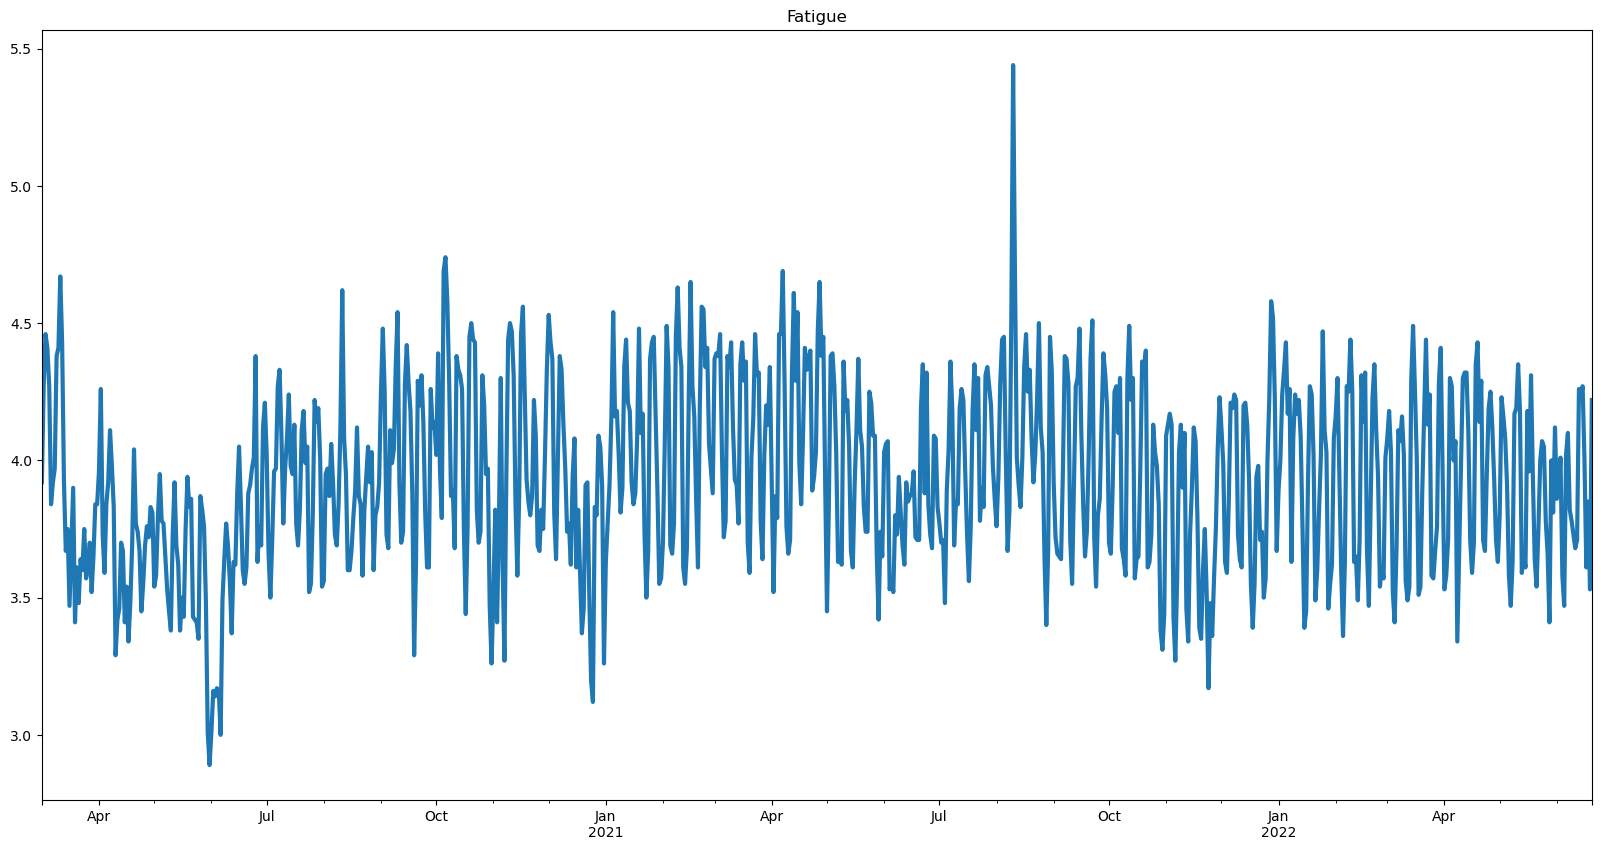

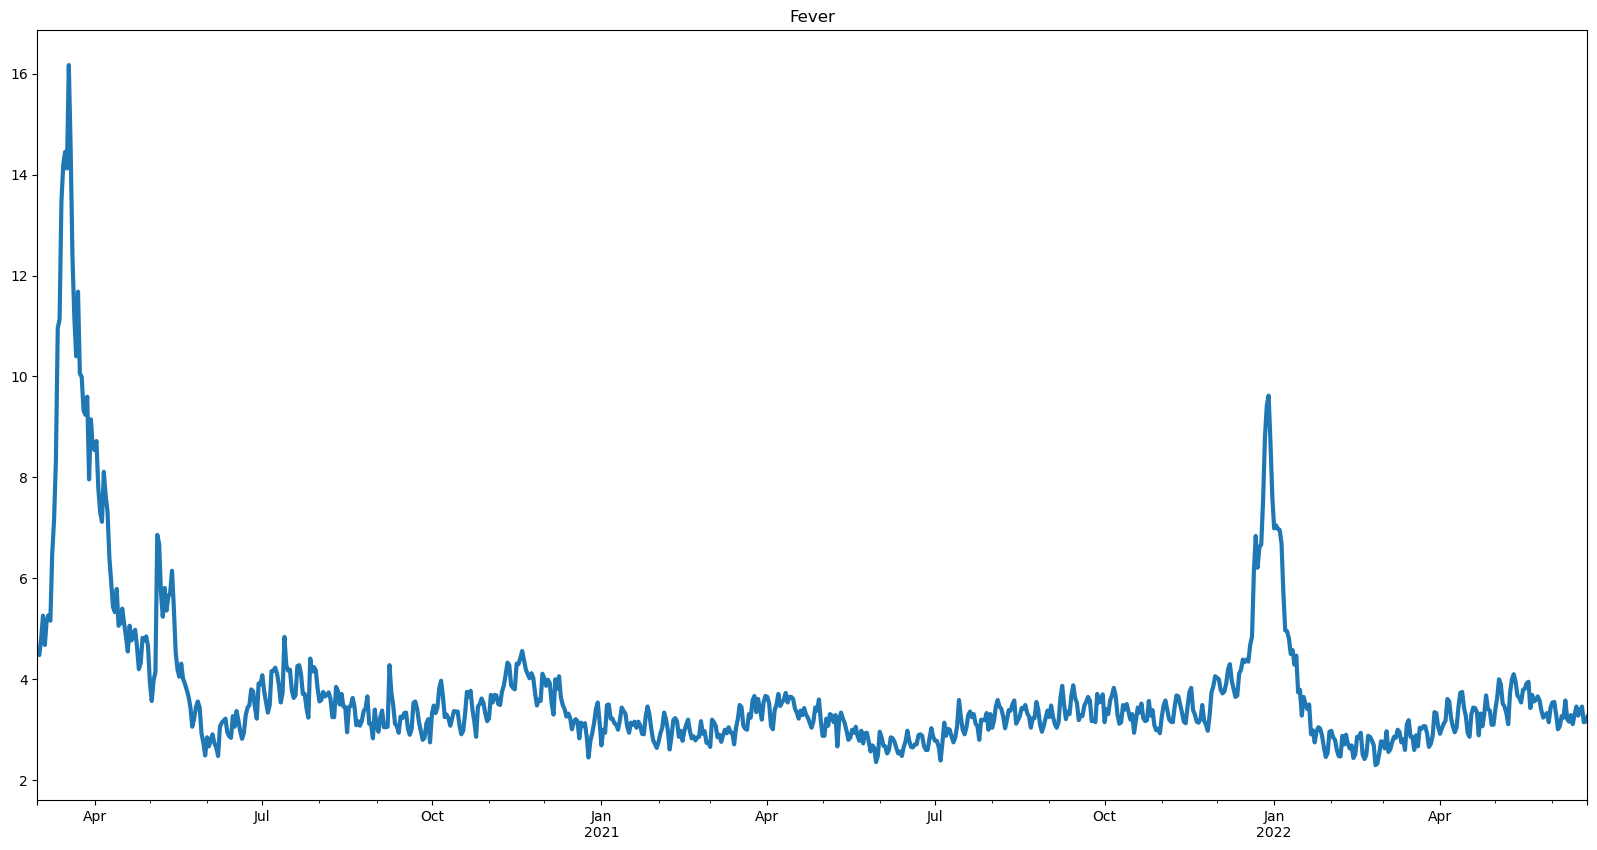

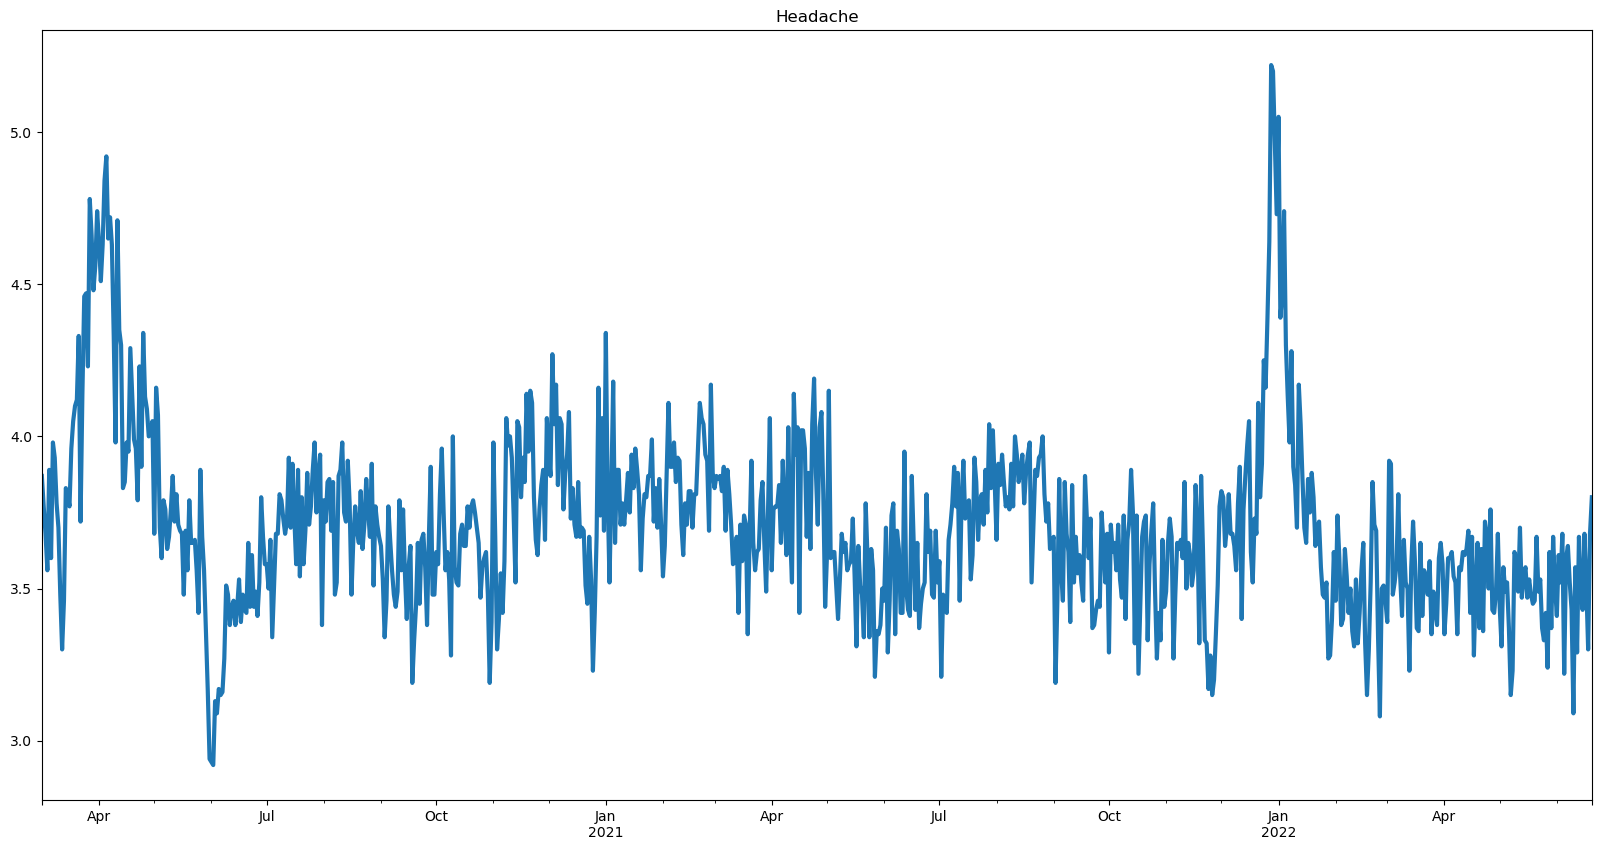

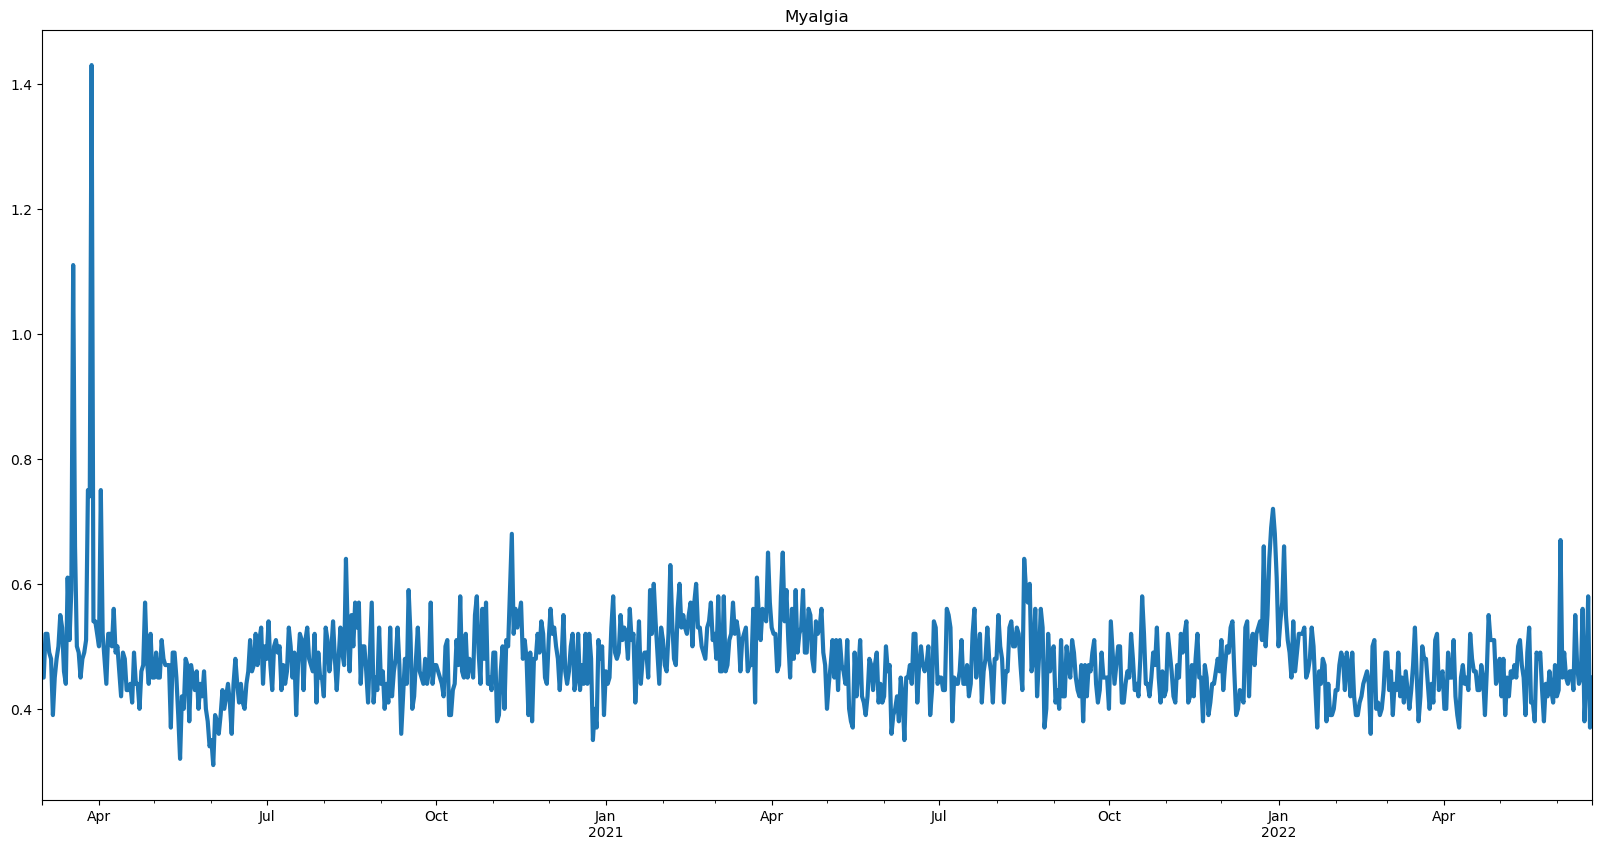

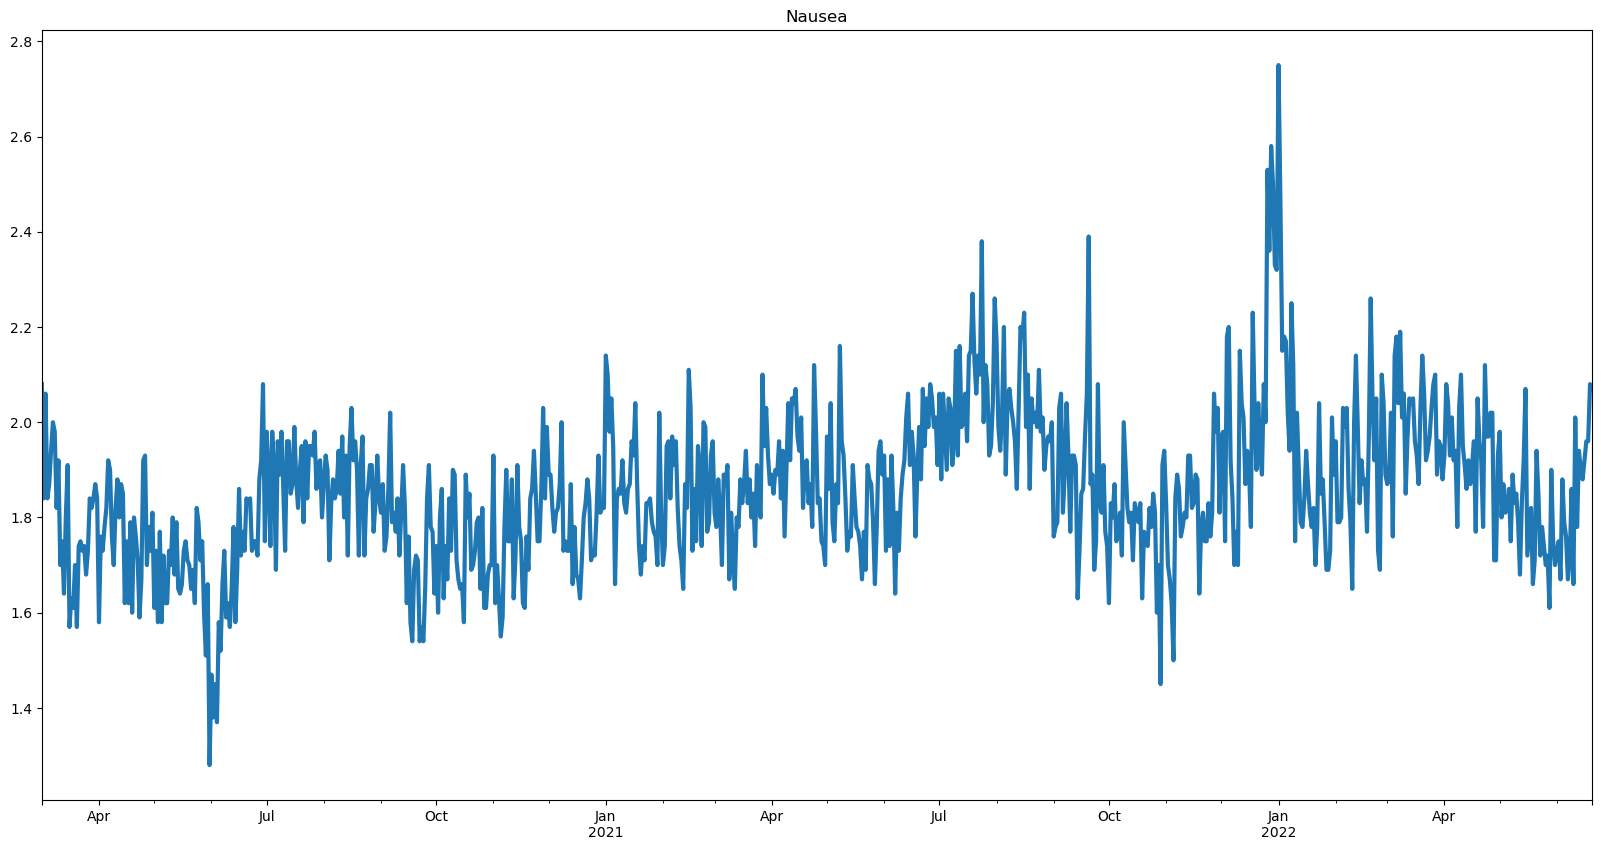

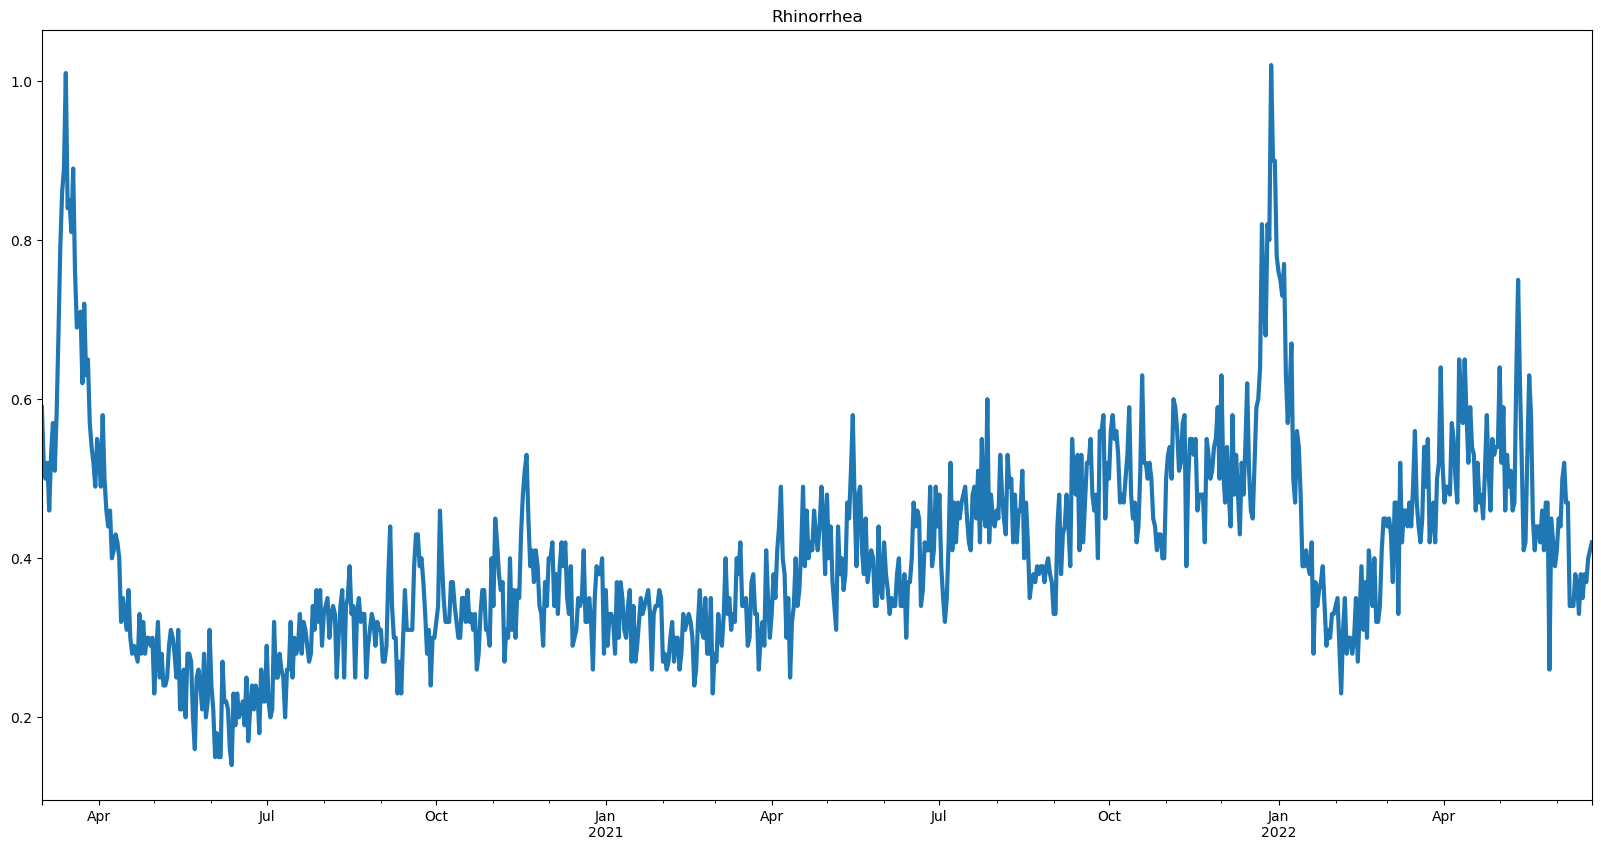

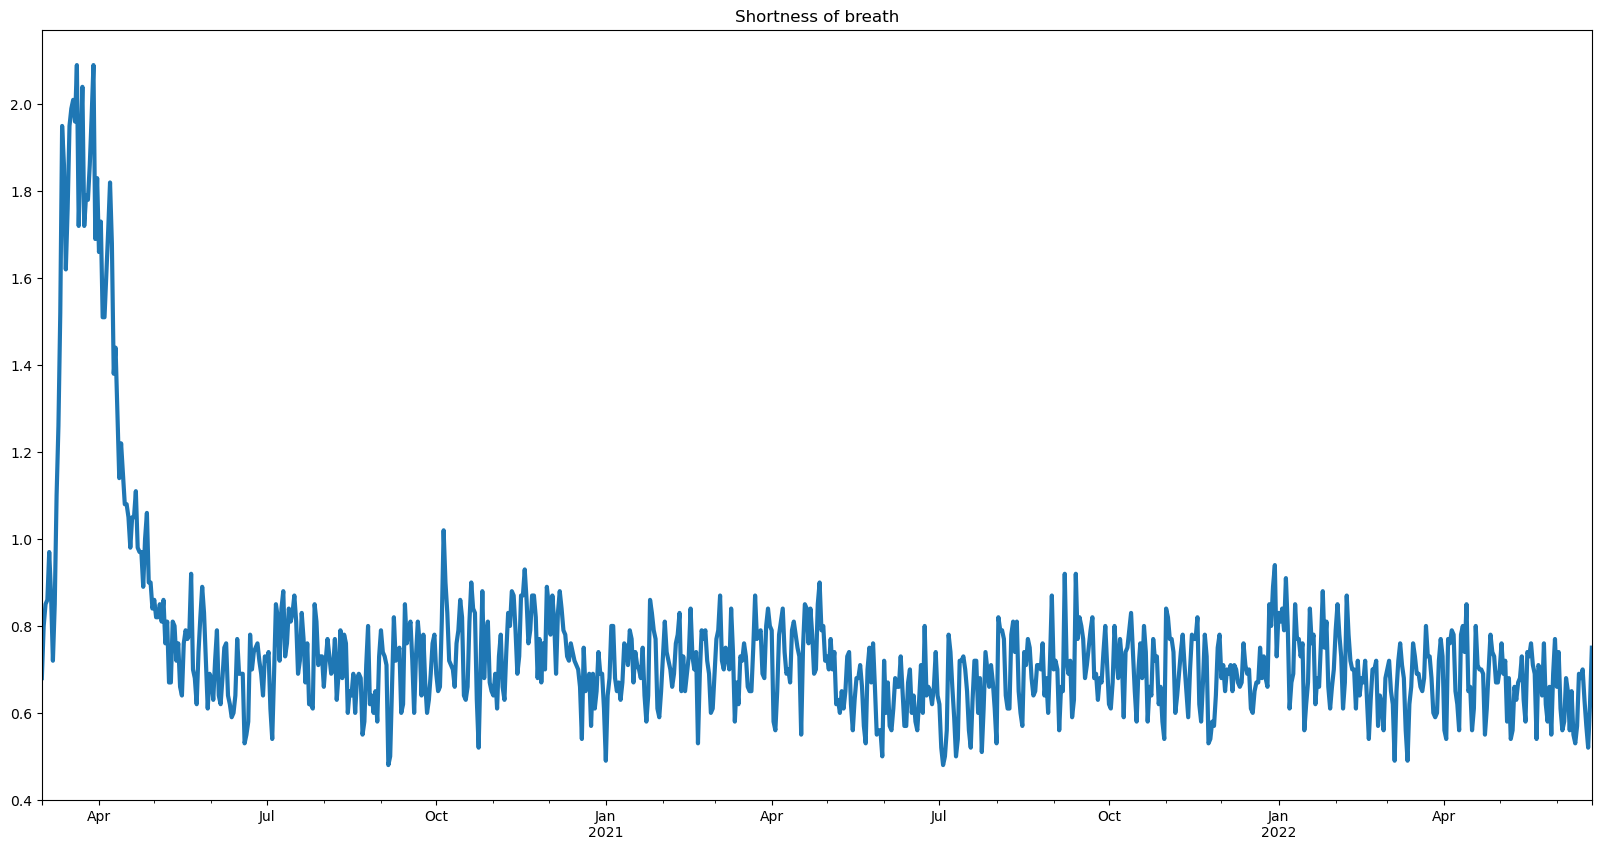

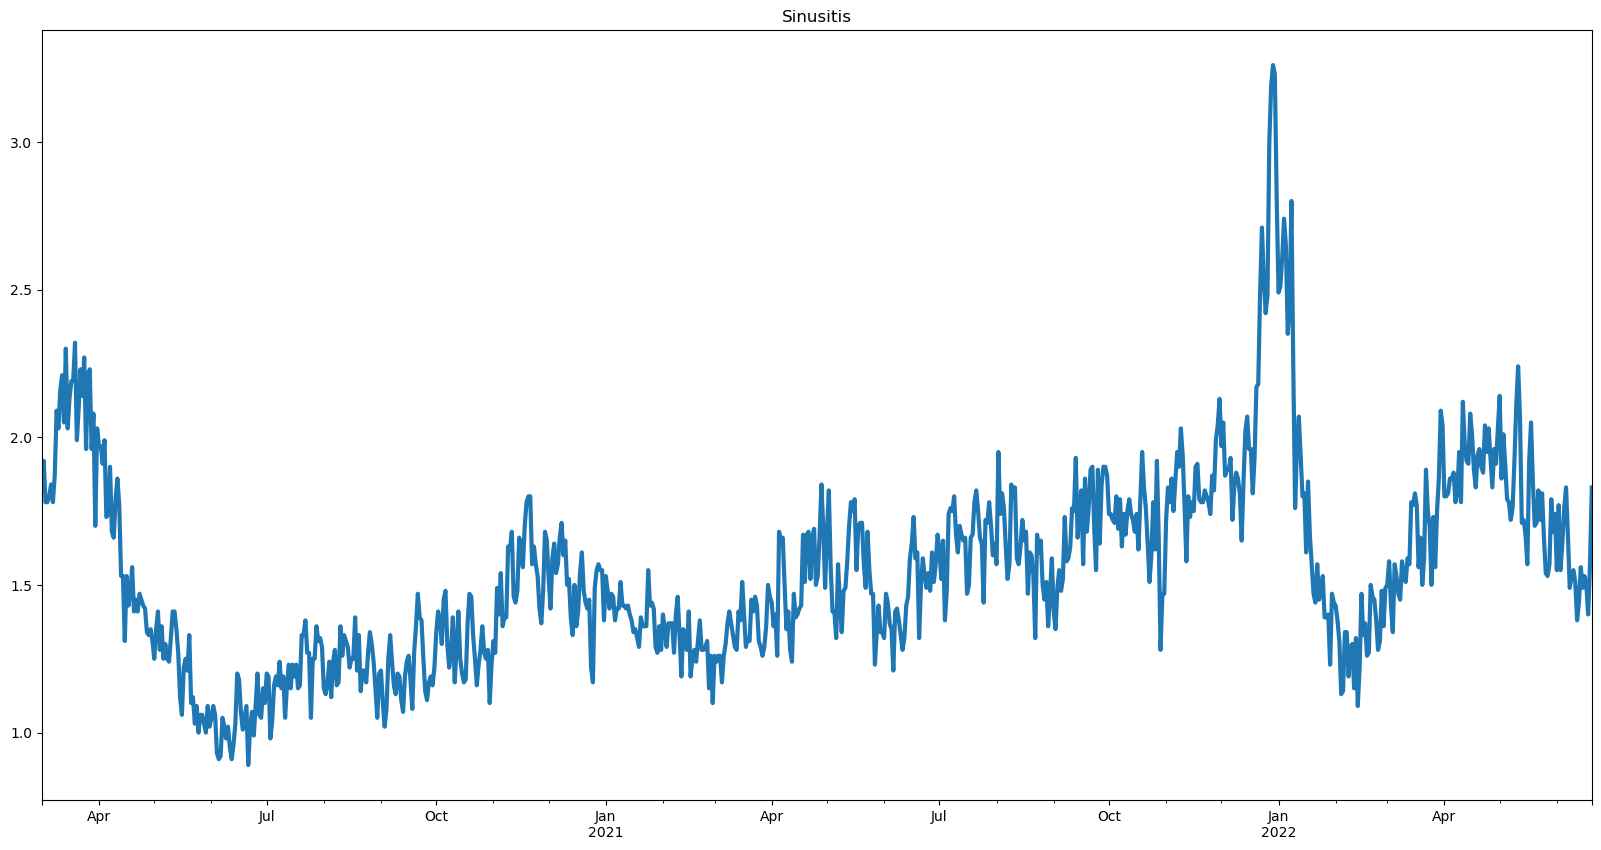

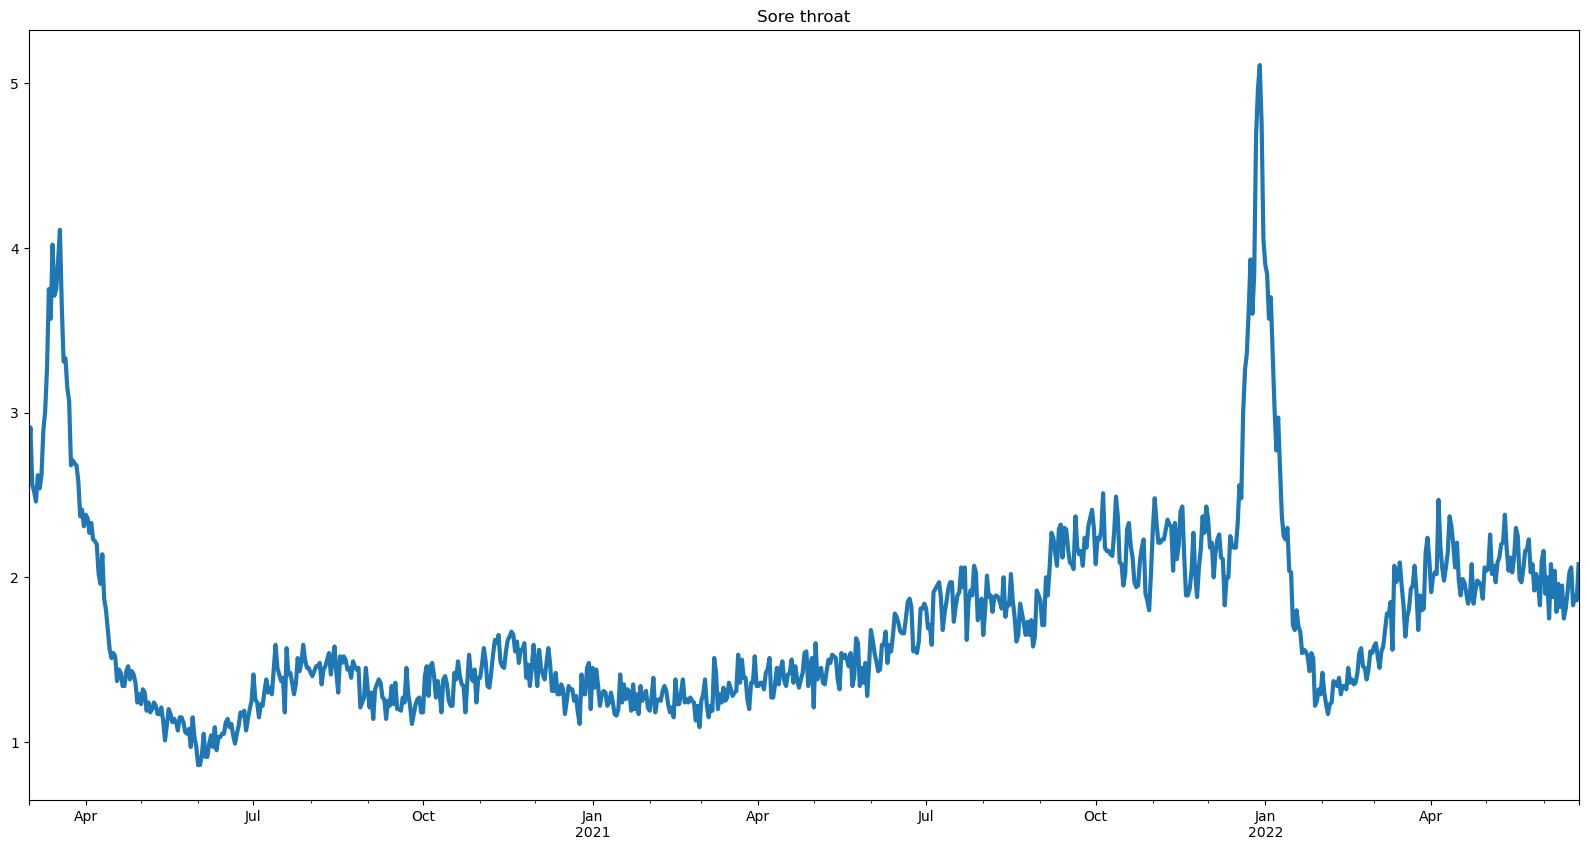

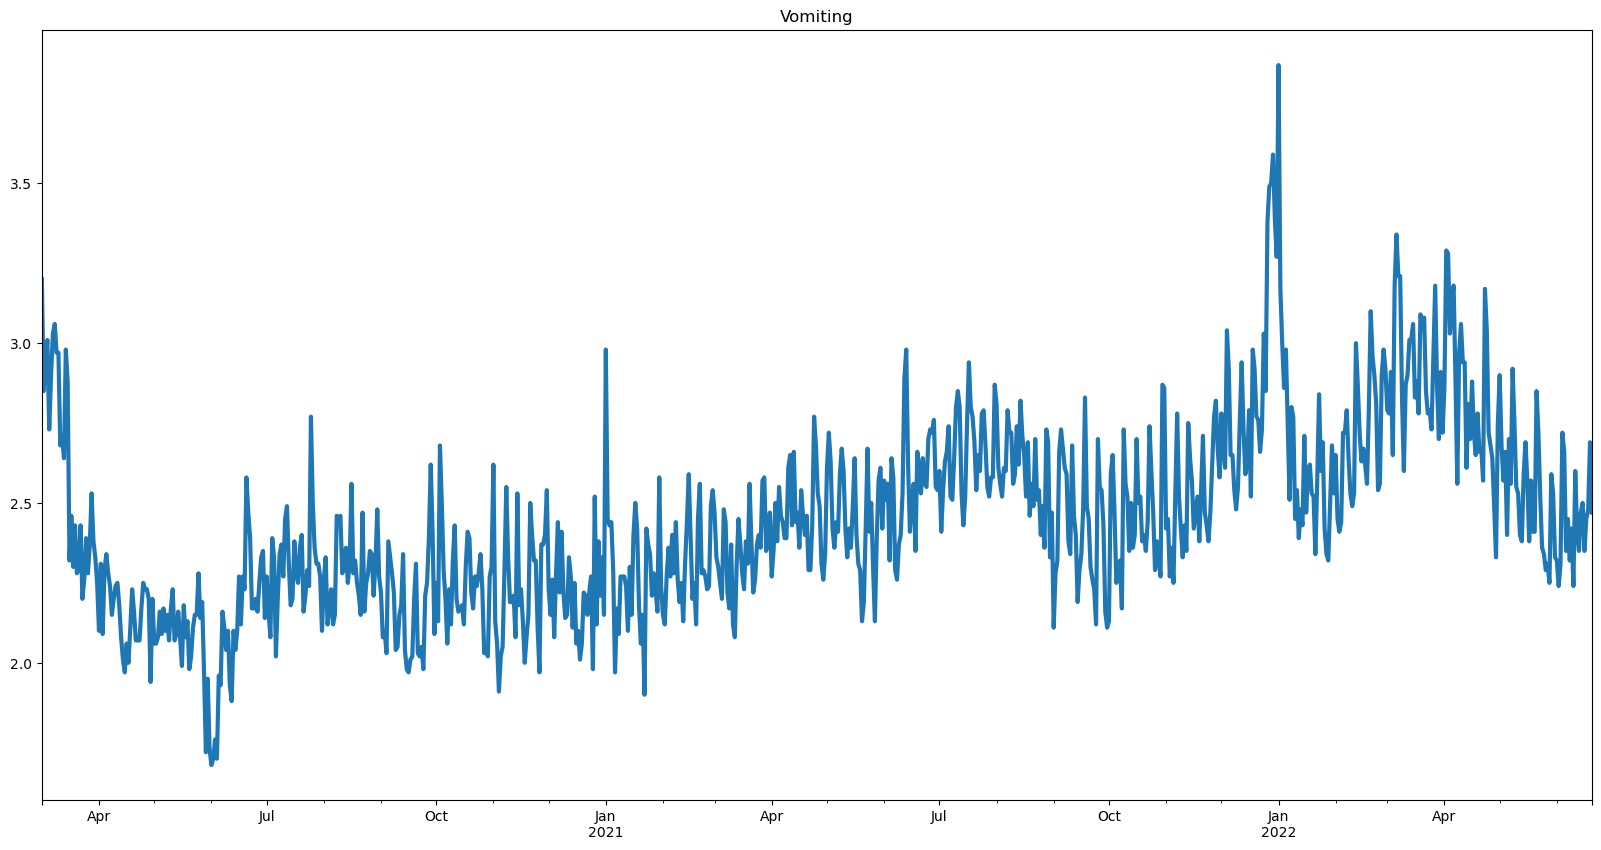

In [33]:
for i in selected_features:
    ax = X_train[i].plot.line(figsize=(20, 10), linewidth=3)
    plt.title(f"{i}")
    plt.show()

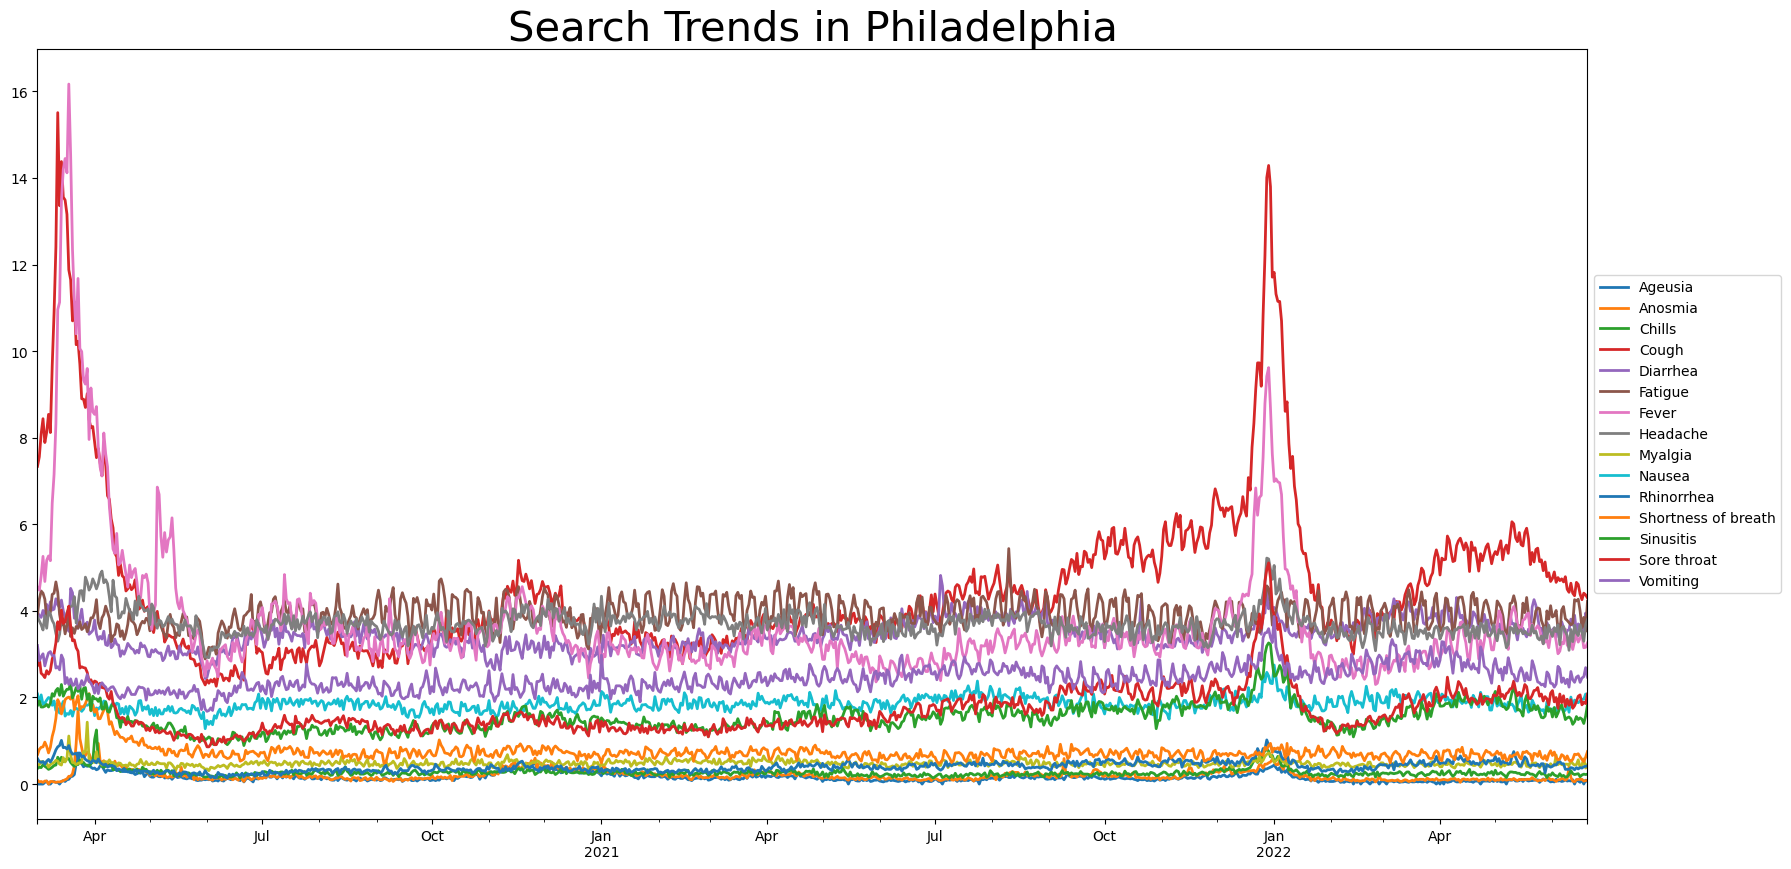

In [34]:
for symp in selected_features:
    ax = X_train[symp].plot.line(figsize=(20, 10), linewidth=2)
    ax.legend(selected_features, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Search Trends in Philadelphia', fontsize=30)

Text(0.5, 1.0, 'New COVID Cases in Philadelphia (Raw)')

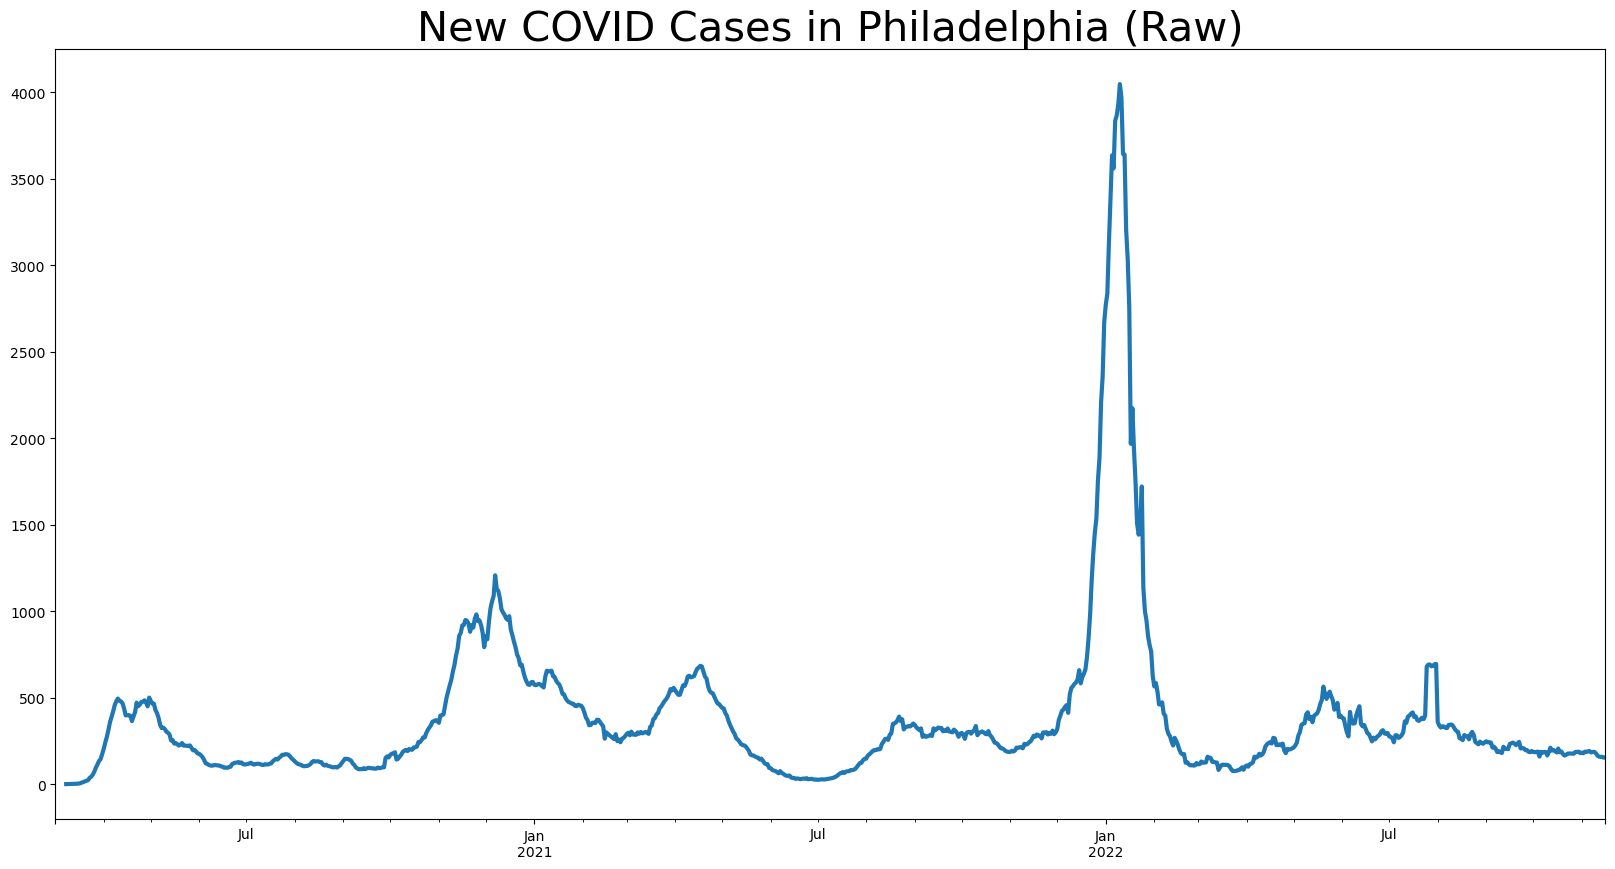

In [35]:
ax = target_cases.plot(figsize=(20, 10), linewidth=3)
plt.title('New COVID Cases in Philadelphia (Raw)', fontsize=30)

Text(0.5, 1.0, 'New COVID Cases in Philadelphia (Minus the 7-Day Rolling Mean)')

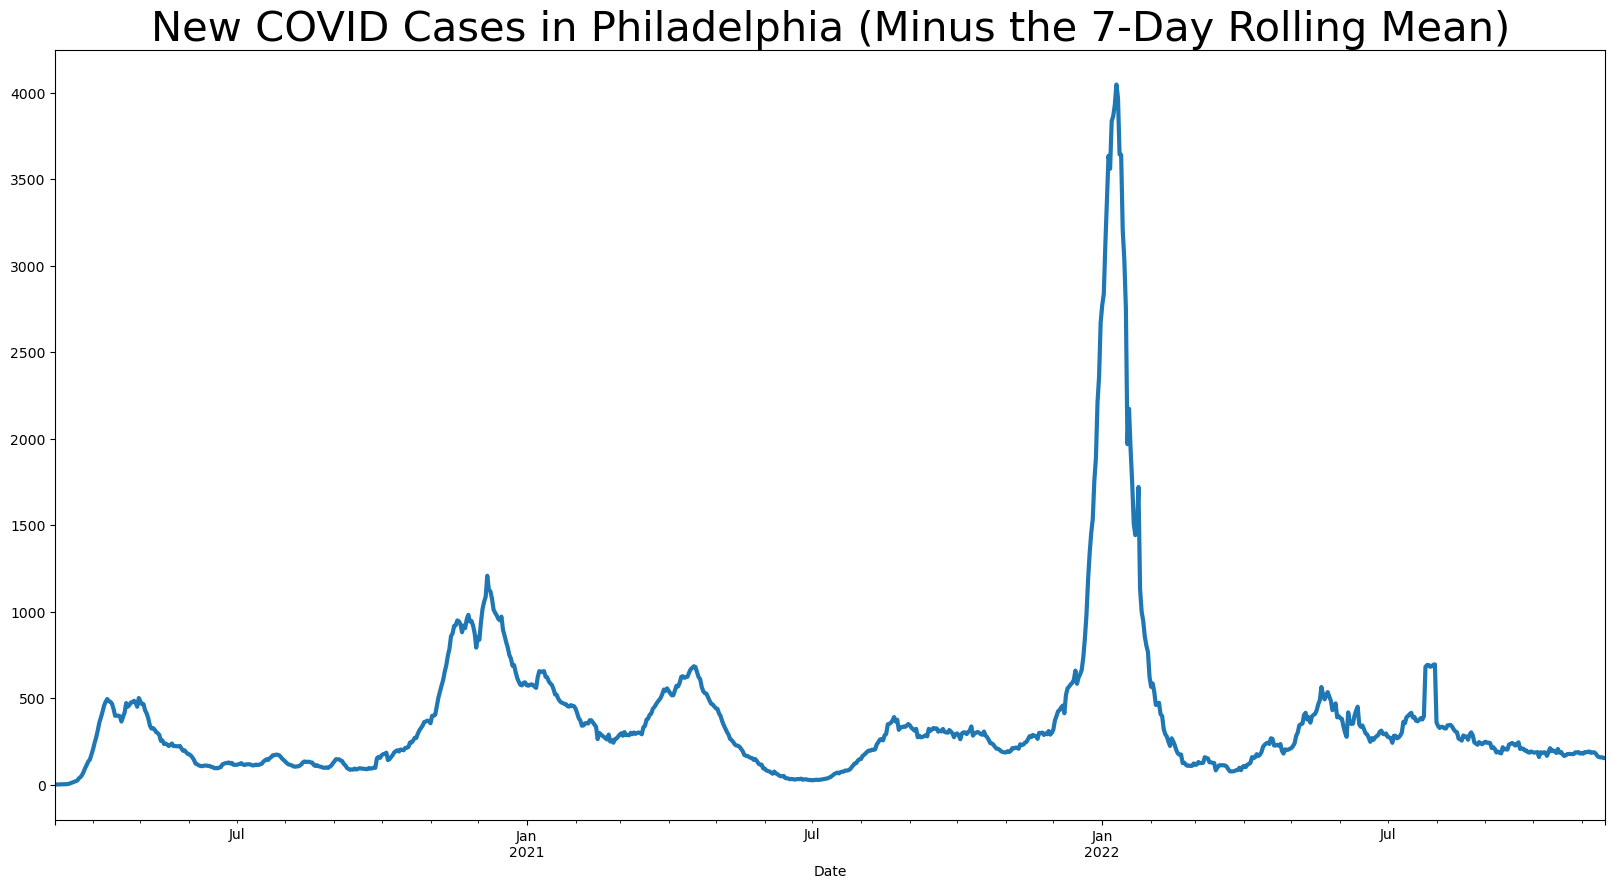

In [36]:
ax = target.plot(figsize=(20, 10), linewidth=3)
plt.title('New COVID Cases in Philadelphia (Minus the 7-Day Rolling Mean)', fontsize=30)

In [37]:
# Dicky Fuller Test for Stationarity
def dicky_fuller(TS):
    result = adfuller(TS)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [38]:
dicky_fuller(y_train)

ADF Statistic: -3.773492
p-value: 0.003190
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569


In [39]:
dicky_fuller(y_train_pre)

ADF Statistic: -2.742567
p-value: 0.066958
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


In [40]:
dicky_fuller(y_train_post)

ADF Statistic: -1.603514
p-value: 0.481828
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574


Trying to take the log function for pre and post omicron to see if that improves stationarity.

In [41]:
post_omicron = philly_data.loc["2022-03-01" :].dropna()
post_omicron_log = np.log(post_omicron)
post_target_log = post_omicron_log['7-day Average New Cases']
post_symptoms_log = post_omicron_log[selected_features]
# post_omicron_log spike train test split 
cutoff_test_post = round(len(post_symptoms)*.85)
cutoff_val_post = round(len(post_symptoms)*.95)

X_train_post_log = post_symptoms_log[:cutoff_test_post]
X_test_post_log = post_symptoms_log[cutoff_test_post: cutoff_val_post]
X_val_post_log = post_symptoms_log[cutoff_val_post:]

y_train_post_log = post_target_log[:cutoff_test_post]
y_test_post_log = post_target_log[cutoff_test_post: cutoff_val_post]
y_val_post_log = post_target_log[cutoff_val_post:]

/Users/rachelsanderlin/opt/anaconda3/envs/covid-env/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [42]:
pre_omicron_log = np.log(pre_omicron)
pre_target_log = pre_omicron_log['7-day Average New Cases']
pre_symptoms_log = pre_omicron_log[selected_features]
# post_omicron_log spike train test split 
cutoff_test_pre = round(len(pre_symptoms)*.85)
cutoff_val_pre = round(len(pre_symptoms)*.95)

X_train_pre_log = pre_symptoms_log[:cutoff_test_post]
X_test_pre_log = pre_symptoms_log[cutoff_test_post: cutoff_val_post]
X_val_pre_log = pre_symptoms_log[cutoff_val_post:]

y_train_pre_log = pre_target_log[:cutoff_test_post]
y_test_pre_log = pre_target_log[cutoff_test_post: cutoff_val_post]
y_val_pre_log = pre_target_log[cutoff_val_post:]

/Users/rachelsanderlin/opt/anaconda3/envs/covid-env/lib/python3.9/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [43]:
dicky_fuller(y_train_post_log)

ADF Statistic: -2.026323
p-value: 0.275152
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574


In [44]:
dicky_fuller(y_train_pre_log)

ADF Statistic: -2.961509
p-value: 0.038649
Critical Values:
	1%: -3.462
	5%: -2.875
	10%: -2.574


In [45]:

#origionally all of the max elements were set to 5, but that took 2+ hours to run, so I lowered it to 3
def sarima_elements(TS):
    '''
This function will calculate the optimal elements to use in our model. The model we will be using following 
this function requires both the time series and the order of elements in order to create the model. 

An ARIMA model requires 3 elements - p, d, and q. This function will cycle through all numbers between 0-2 
to find the optimal values for these elements.

p - this is the order of the auto-regressive (AR) part of the ARIMA model. This states the lag we want to 
incorporate into our model, thereby enabling our model to take the past into consideration. 
d - integrated (I) part of the model, which states the order of 
how many times the model has been differenced to find optimal  stationarity.
q - this is the moving average (MA) order of the ARIMA model, which represents the error found in the model. 

The seasonal ARIMA contains these three elements along with a seasonal element, set here as 30, to represent 
the approximate number of days in each month.  
    '''
    auto = pm.auto_arima(TS, start_p=0, start_q=0, max_p=7,
                  max_q=3, max_d=3, start_P=0, start_Q=0, max_P=3,
                  max_Q=3, m=52, max_order=None, stepwise=True, 
                  trace=True, random_state = 42)
    return auto

In [ ]:
%%time
pre_target_elements = sarima_elements(y_train_pre_log)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=732.553, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=inf, Time=10.35 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=1324.670, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=703.825, Time=4.70 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=700.362, Time=49.14 sec
 ARIMA(0,0,0)(3,0,0)[52] intercept   : AIC=702.056, Time=127.02 sec
 ARIMA(0,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=33.08 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=inf, Time=6.33 sec
 ARIMA(0,0,0)(3,0,1)[52] intercept   : AIC=inf, Time=97.80 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=inf, Time=26.15 sec
 ARIMA(0,0,1)(2,0,0)[52] intercept   : AIC=437.875, Time=23.57 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=439.585, Time=3.39 sec


In [ ]:
%%time
post_target_elements = sarima_elements(y_train_post_log)

In [ ]:
def plot_model_and_prediction(prediction_pred, df_train, df_test, symptom): 
    #plot our model and it's predicted values
    fig, ax = plt.subplots(figsize=(12, 8))
    #ax.plot(df_train, label='Training Data')
    #ax.plot(df_test, label='Testing Data')
    #prediction_auto.plot(ax=ax, label='Forecasted Value')
    ax.plot(prediction_pred, label = 'Trained Model')
    plt.title(f"{symptom} Forcast", fontsize=30)
    ax.set_xlabel('Months')
    ax.set_ylabel('Number of Cases')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
pre_ARIMA_MODEL = sm.tsa.statespace.SARIMAX((y_train_pre), order=pre_target_elements.order,
                                            seasonal_order=pre_target_elements.seasonal_order,
                                            enforce_stationarity=False, enforce_invertibility=False)

    # Fit the model and return the results
pre_output = pre_ARIMA_MODEL.fit()

pre_output_forcast = pre_output.get_forecast(steps= 100)
pre_output_conf= pre_output_forcast.conf_int()

In [ ]:
pre_output_forcast = pre_output.get_forecast(steps= 100)
pre_output_forcast.summary_frame()

In [ ]:
pre_output_pred = pre_output.get_forecast(steps = 100)
pre_output_pred

In [ ]:
pre_target_elements.plot_diagnostics(figsize=(12,8))
pre_target_elements.summary()

In [ ]:
y_test_pre

In [ ]:
#plot_model_and_prediction(pre_output_pred, y_train_pre, y_test_pre, "Number of Cases Pre-Omicron")

In [ ]:
y_train_pre

In [ ]:
y_test_pre.index

In [ ]:
forecast.predict

In [ ]:
#plot our model and it's predicted values
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y_train_pre, label='Training Data')
ax.plot(y_test_pre, label='Testing Data')
#prediction_auto.plot(ax=ax, label='Forecasted Value')
forecast = pre_output.get_forecast(steps='2021-10-02').summary_frame()
#forecast.predicted_mean.plot(ax=ax, label='Forecasted Value')
ax.plot(forecast['mean'], label='SARIMAX Forecast')
ax.set_xlabel('Dates')
ax.set_ylabel('Number of Cases')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
forecast

In [ ]:
print('MAE:', np.mean(abs(forecast['mean'] - y_test_pre.values)))
print('RMSE:', np.sqrt(np.mean((forecast['mean'] - y_test_pre.values)**2)))
print('MAPE:', np.mean(abs((forecast['mean'] - y_test_pre.values)/y_test_pre.values)))

In [ ]:
post_ARIMA_MODEL = sm.tsa.statespace.SARIMAX((y_train_post), order=post_target_elements.order,
                                            seasonal_order=post_target_elements.seasonal_order,
                                            enforce_stationarity=False, enforce_invertibility=False)

    # Fit the model and return the results
post_output = post_ARIMA_MODEL.fit()

post_output_forcast = post_output.get_forecast(steps= 100)
post_output_conf= post_output_forcast.conf_int()

In [ ]:
post_target_elements = sarima_elements(y_train_post)

In [ ]:
post_target_elements.plot_diagnostics(figsize=(12,8))
post_target_elements.summary()

In [ ]:
plot_model_and_prediction(post_output_forcast, y_train_post, y_test_post, "Number of Cases Post-Omicron")

In [ ]:
%%time
target_elements = sarima_elements(y_train)


In [ ]:
target_elements.plot_diagnostics(figsize=(12,8))
target_elements.summary()


In [ ]:
target_elements.order

In [ ]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX((y_train), order=(7,1,0), seasonal_order=(0,0,0,52),
                                            enforce_stationarity=False, enforce_invertibility=False)

    # Fit the model and return the results
output = ARIMA_MODEL.fit()

output_forcast = output.get_forecast(steps= 100)

In [ ]:
output_conf= output_forcast.conf_int()

In [ ]:
plot_model_and_prediction(output_forcast, y_train, y_test, "New Cases")

In [ ]:
decomposition = sm.tsa.seasonal_decompose(y_train, model='additive', 
                            extrapolate_trend='freq') #additive or multiplicative is data specific
fig = decomposition.plot()
plt.show()